# 14. 반복 서치

In [2]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()
library(ggforce)

In [3]:
data(cells)
cells <- cells %>% select(-case)

set.seed(1304)
cell_folds <- vfold_cv(cells)

roc_res <- metric_set(roc_auc)

- 그리드 서치는 사전 정의된 후보 값 집합을 취하여 이를 평가하고 최적의 설정을 선택하는 방법
- **반복 서치는 다른 전략을 추구. 검색 프로세스 중에 다음 테스트를 수행할 값을 예측**



- 그리드 검색이 불가능하거나 비효율적일 때, 반복 서치는 파라미터 튜닝을 최적화하는 합리적인 접근 방식

ㅡ

## 14.1 SVM
- 최적화할 두 가지 파라미터는 SVM Cost 값과, 방사형 기본 함수 커널 매개 변수 $\sigma$
- 두 파라미터 모두 모델의 복잡성과 성능에 큰 영향을 미침
- SVM 모델은 다층 퍼셉트론 모델과 마찬가지로, 이 모델은 PCA의 사용으로 이익을 얻을 수 있음. 
- ```sv_rec```, ```sv_spec``` 및 ```sv_wflow```은 모델 프로세스를 정의



In [4]:
svm_rec <- recipe(class ~ ., data = cells) %>%
    step_YeoJohnson(all_numeric_predictors()) %>%
    step_normalize(all_numeric_predictors())

In [5]:
svm_spec <- svm_rbf(cost = tune(), rbf_sigma = tune()) %>% 
    set_engine("kernlab") %>% 
    set_mode("classification")

In [6]:
svm_wflow <- workflow() %>% 
    add_model(svm_spec) %>% 
    add_recipe(svm_rec)

- 두 튜닝 파라미터 ```cost``` 및 ```rbf_sigma```에 대한 기본 매개 변수 범위는 다음과 같음 :


In [7]:
cost()

Cost (quantitative)
Transformer: log-2 [1e-100, Inf]
Range (transformed scale): [-10, 5]

In [8]:
rbf_sigma()

Radial Basis Function sigma (quantitative)
Transformer: log-10 [1e-100, Inf]
Range (transformed scale): [-10, 0]

- 커널 매개 변수 범위를 약간 변경하여 서치의 시각화를 개선

In [9]:
svm_param <- svm_wflow %>% 
    extract_parameter_set_dials() %>% 
    update(rbf_sigma = rbf_sigma(c(-7, -1)))

# 
# 

- 2,500개의 후보 값으로 구성된 매우 큰 정규 그리드를 구성하고 리샘플링을 사용하여 그리드를 평가시,  비현실적이고 정기적인 데이터 분석에서 엄청나게 비효율적이나, 그러나 검색 서치 프로세스가 취해야 할 경로와 수치 최적 값이 발생하는 위치를 설명할 수 있음



# 
# 

#### 튜닝 파라미터 값의 고밀도 그리드에 대한 ROC 곡선 아래의 평균 면적 히트맵
    - 가장 좋은 point는 오른쪽 상단 모서리에 있는 point


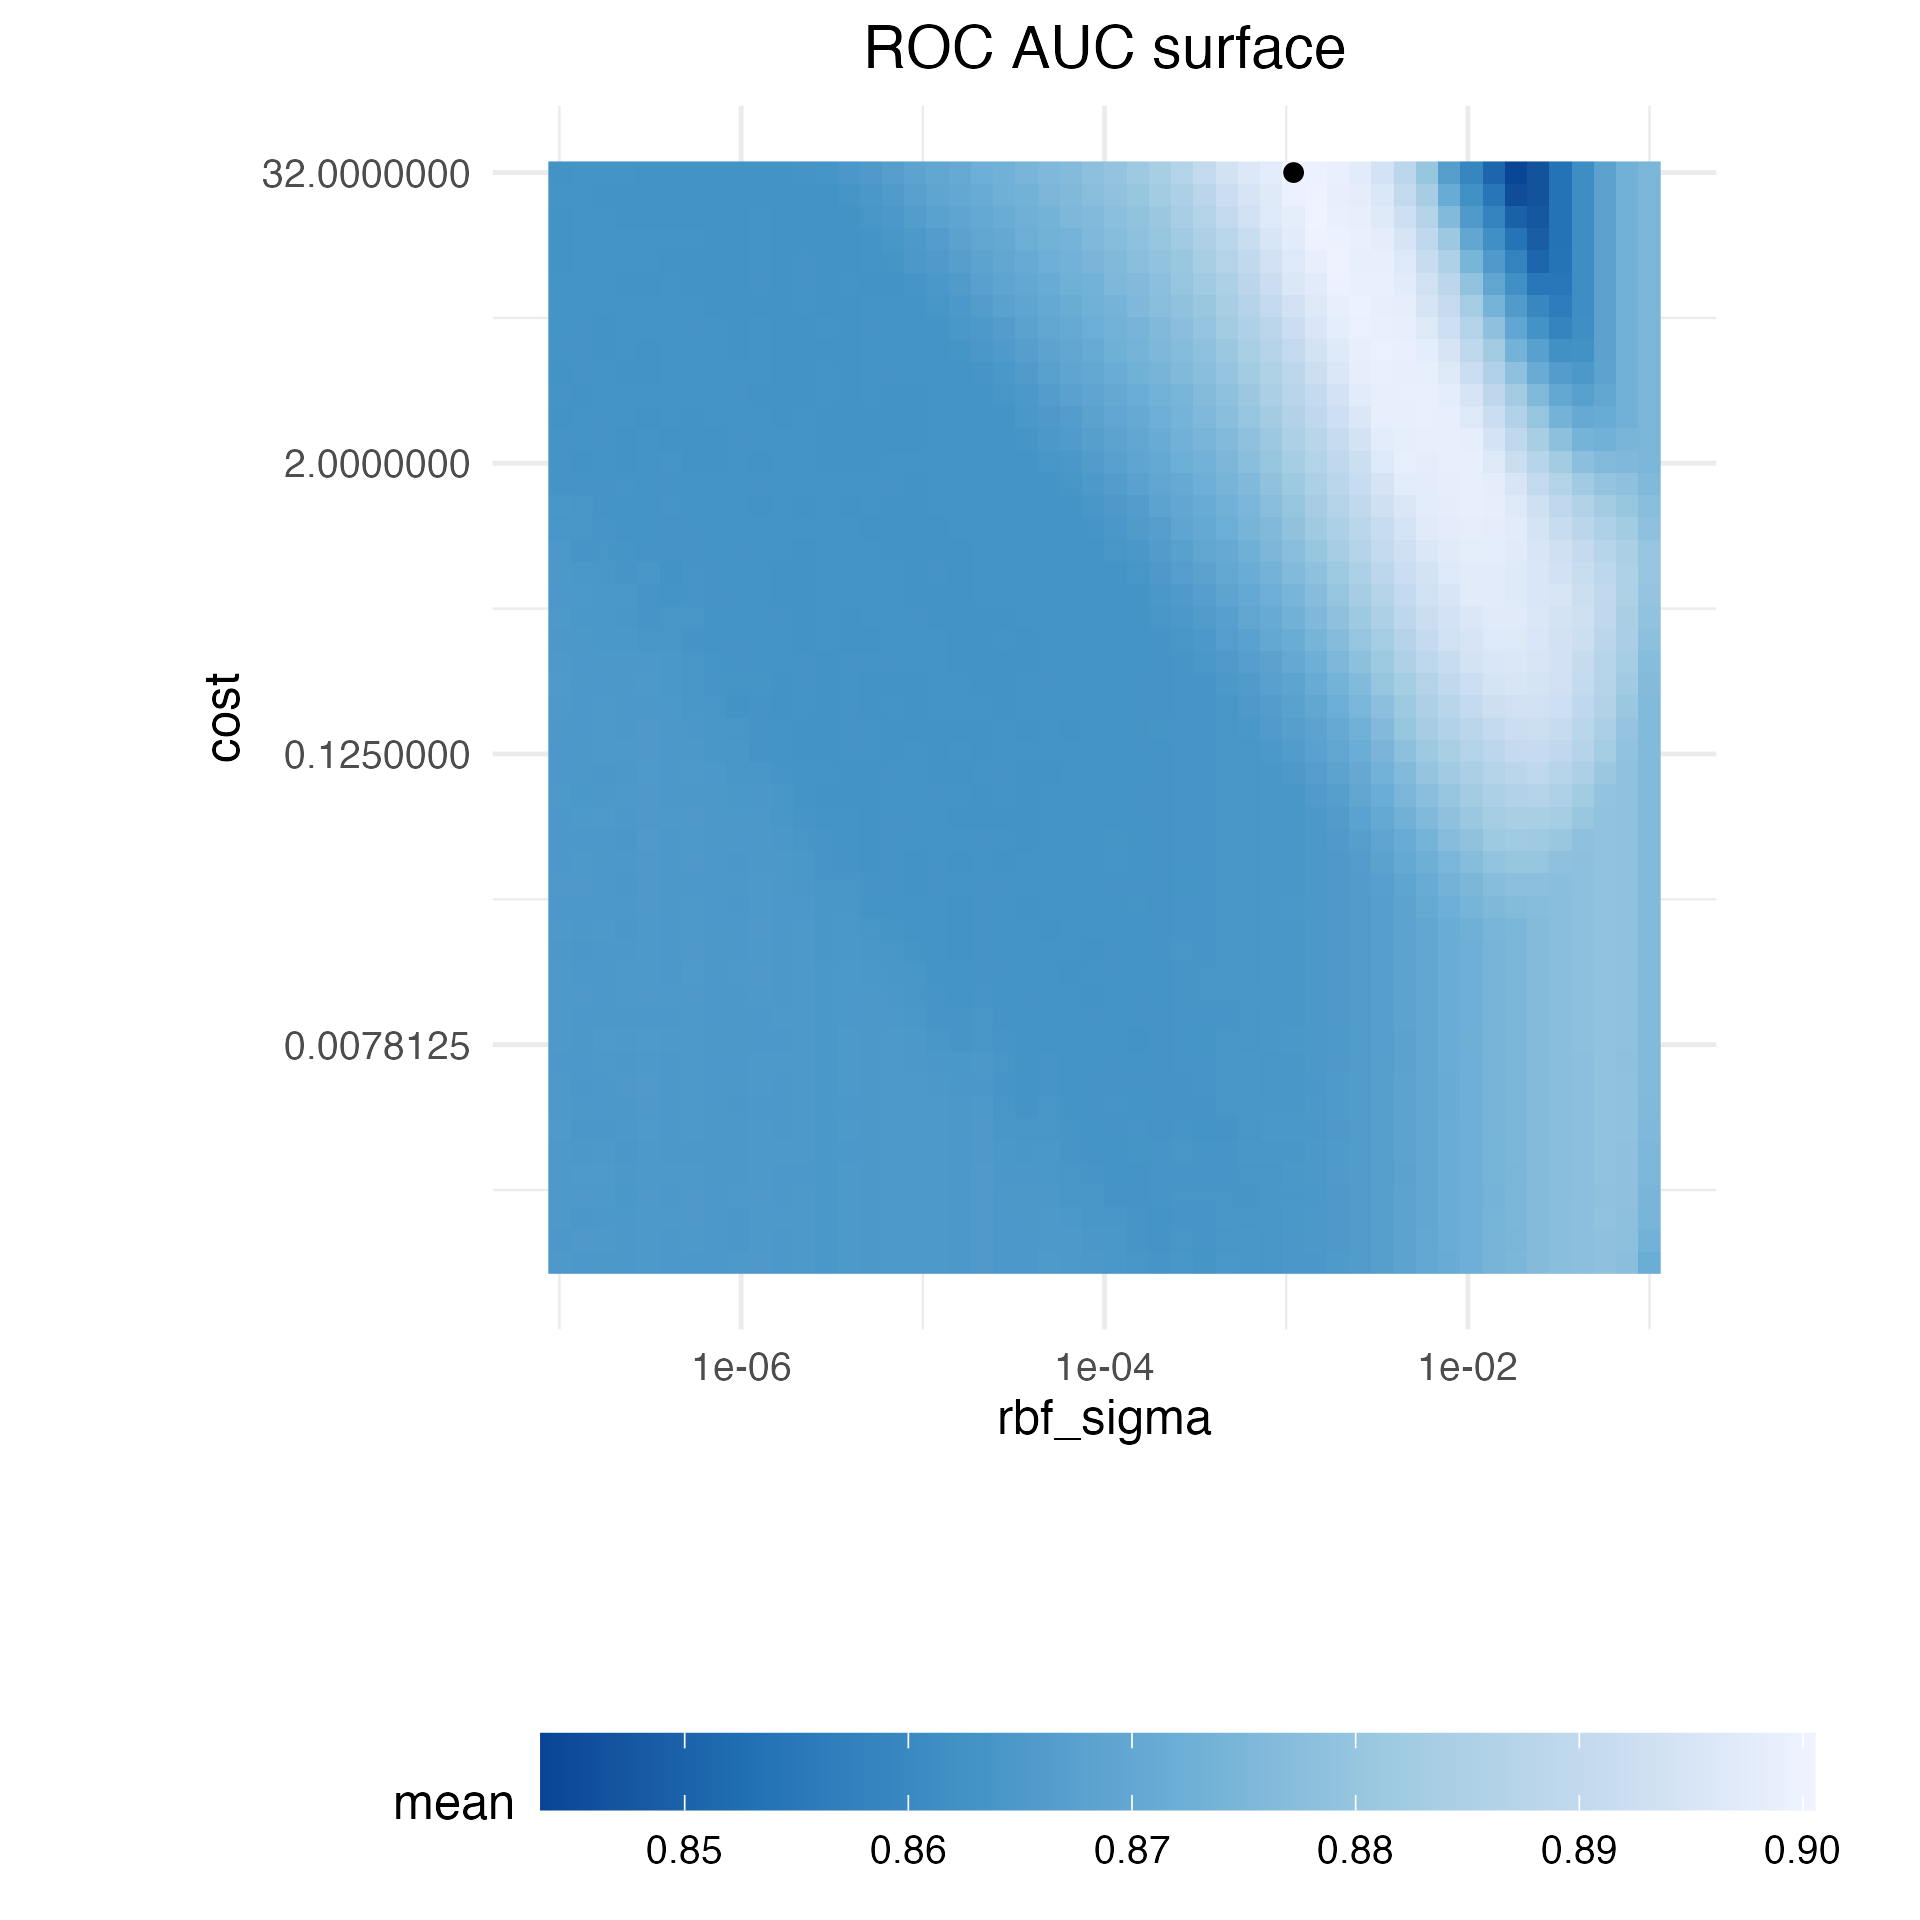



- 파라미터 공간의 하부 대각선에는 상대적으로 평탄하고 성능이 떨어지는 큰 구역이 존재. 
- 최고 성능의 능선은 공간의 오른쪽 상단에서 발생. 
- 검은색 점은 최상의 설정을 나타냄. 
- 저조한 결과의 고원에서 최상의 성능의 고지로의 전환은 경사는 높음. 
- 능선 바로 오른쪽에 있는 ROC 곡선 아래 지역도 급강하

# 
# 
#### **반복 서치 절차 수행 전, 리샘플링 모델에 대한 성능 통계가 필요**
- 이를 위해 파라미터 공간의 작은 정규 그리드를 생성

In [10]:
set.seed(1401)
start_grid <- svm_param %>% 
    update(cost = cost(c(-6, 1)),
           rbf_sigma = rbf_sigma(c(-6, -4))) %>% 
    grid_regular(levels = 2)

In [13]:
start_grid

cost,rbf_sigma
<dbl>,<dbl>
0.015625,1e-06
2.000000,1e-06
0.015625,1e-04
2.000000,1e-04


In [14]:
set.seed(1402)
svm_initial <- svm_wflow %>% 
    tune_grid(resamples = cell_folds, grid = start_grid, metrics = roc_res)

In [15]:
collect_metrics(svm_initial)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.015625,1e-06,roc_auc,binary,0.8638724,10,0.008637894,Preprocessor1_Model1
2.000000,1e-06,roc_auc,binary,0.8625326,10,0.008672545,Preprocessor1_Model2
0.015625,1e-04,roc_auc,binary,0.8627495,10,0.008624554,Preprocessor1_Model3
2.000000,1e-04,roc_auc,binary,0.8659439,10,0.008545691,Preprocessor1_Model4


- 이러한 결과는 초기 값으로 사용하기 위해 다음 섹션에서 설명하는 반복 튜닝 기능에 의해 수집될 수 있음



# 
# 
# 
### 가우시안 프로세스 모델
- 가우시안 프로세스(GP) 모델은 공간 통계(크라이깅 방법이라는 이름으로)에 역사가 있는 잘 알려진 통계 기법
- 베이지안 모델을 포함하여 여러 가지 방법으로 도출 가능

# 

- 수학적으로 GP는, 공동 확률 분포가 다변량 가우스인 랜덤 변수의 집합
- 이것은 튜닝 파라미터 후보 값에 대한 성능 메트릭의 모음
- **이전 4개 표본의 초기 그리드의 경우, 이들 4개 랜덤 변수의 실현도는 0.8639, 0.8625, 0.8627, 0.8659였고. 이것 들을 다변량 가우시안으로서 분포된다고 가정**




# 

In [19]:
collect_metrics(svm_initial) %>% 
    select(ROC = mean, cost, rbf_sigma) %>% 
    as.data.frame()

ROC,cost,rbf_sigma
<dbl>,<dbl>,<dbl>
0.8638724,0.015625,1e-06
0.8625326,2.000000,1e-06
0.8627495,0.015625,1e-04
0.8659439,2.000000,1e-04


# 
- **가우시안 프로세스 모델은 평균 및 공분산 함수에 의해 지정되지만, 공분산 함수가 GP 모델의 특성에 가장 큰 영향을 미침**
- 공분산 함수는 종종 입력 값($x$)으로 모수화됨 (일반적으로 사용되는 공분산 함수는 제곱 지수 함수)

$\operatorname{cov}(\boldsymbol{x}_i, \boldsymbol{x}_j) = \exp\left(-\frac{1}{2}|\boldsymbol{x}_i - \boldsymbol{x}_j|^2\right) + \sigma^2_{ij}$
    - $\sigma_{ij}^2$는 $i = j$일 때 0인 상수 오차 분산 항. 이 방정식은 다음과 같이 해석 :
        - 두 튜닝 파라미터 조합 간의 거리가 증가함에 따라, 성능 메트릭 간의 공분산은 기하급수적으로 증가
        - 또한, 결과 메트릭의 변동이 이미 관찰된 지점(즉, $|x_i - x_j|^2$가 0일 때)에서 최소화된다는 것을 의미

# 

- **이 공분산 함수의 특성으로 인해 가우시안 프로세스는 적은 양의 데이터만 존재하는 경우에도 모델 성능과 튜닝 매개 변수 사이의 매우 비선형적인 관계를 나타낼 수 있음**
- 그러나 이러한 모델을 적합하는 것은 경우에 따라 어려울 수 있으며, 모델은 튜닝 파라미터 조합의 수가 증가함에 따라 계산 비용이 더 많이 듬

# 

- 이 모델의 중요한 장점은 전체 확률 모델이 지정되기 때문에 새로운 입력값에 대한 예측이, 결과의 전체 분포를 반영할 수 있다는 것. 다시 말해, **새로운 성능 통계량은 평균과 분산의 관점에서 모두 예측될 수 있음**











# 
# 
- 추가 샘플링을 위해 고려된 두 가지 튜닝 파라미터의 예시
    - 두 개의 새로운 튜닝 파라미터에 대해. A는 B보다 약간 더 나은 평균 ROC 값을 갖는다(현재 최고는 0.8659). 그러나 분산이 B보다 4배 더 큼
    - 옵션 A를 선택하는 것은 더 위험하지만 잠재적으로 더 높은 수익률을 가지고 있음. 

In [20]:
best_val <- max(collect_metrics(svm_initial)$mean)

tmp <- tibble(candidate = LETTERS[1:2], .mean = c(.90, .89), .sd = c(0.02, 0.005))

tmp %>% select(candidate, mean = .mean, variance = .sd) %>% 
    mutate(variance = variance^2) %>% 
    as.data.frame()

candidate,mean,variance
<chr>,<dbl>,<dbl>
A,0.90,4.0e-04
B,0.89,2.5e-05


# 
# 
### 획득 함수
- **본래의 목표는 현재 최고보다 "더 나은 결과"를 얻을 가능성이 가장 높은 다음 튜닝 파라미터 조합을 선택하는 것**
- 이를 위한 한 가지 접근 방식은 큰 후보 집합을 만든 다음, 각각에 대해 평균 및 분산 예측을 하는 것. 
- 이 정보를 사용하여 가장 유리한 튜닝 매개 변수 값을 선택

# 

- 획득 함수라고 하는 목적 함수의 클래스는 평균과 분산 사이의 균형을 용이하게 만듬. 
- GP 모형의 예측 분산은 대부분 기존 데이터로부터 얼마나 멀리 떨어져 있는지에 따라 결정
- **새로운 후보들에 대한 예측 평균과 분산 사이의 균형은 '탐색(Exploration)'와 '착취 (Exploitation)'의 관점에서 관찰**


    - 탐색(Exploration)은 관측된 후보 모델이 적은 지역으로 선택을 편향시킴. 이는 분산이 더 높은 후보에게 더 많은 가중치를 부여하는 경향이 있으며 새로운 결과를 찾는 데 중점.

    - 착취(Exploitation) 주로 평균 예측에 의존하여 최상의 (평균) 값을 탐색. 기존 결과에 초점


# 
- 추정된 5개의 점이 있는 임의의 튜닝 파라미터에 대한 가상의 실제 성능 

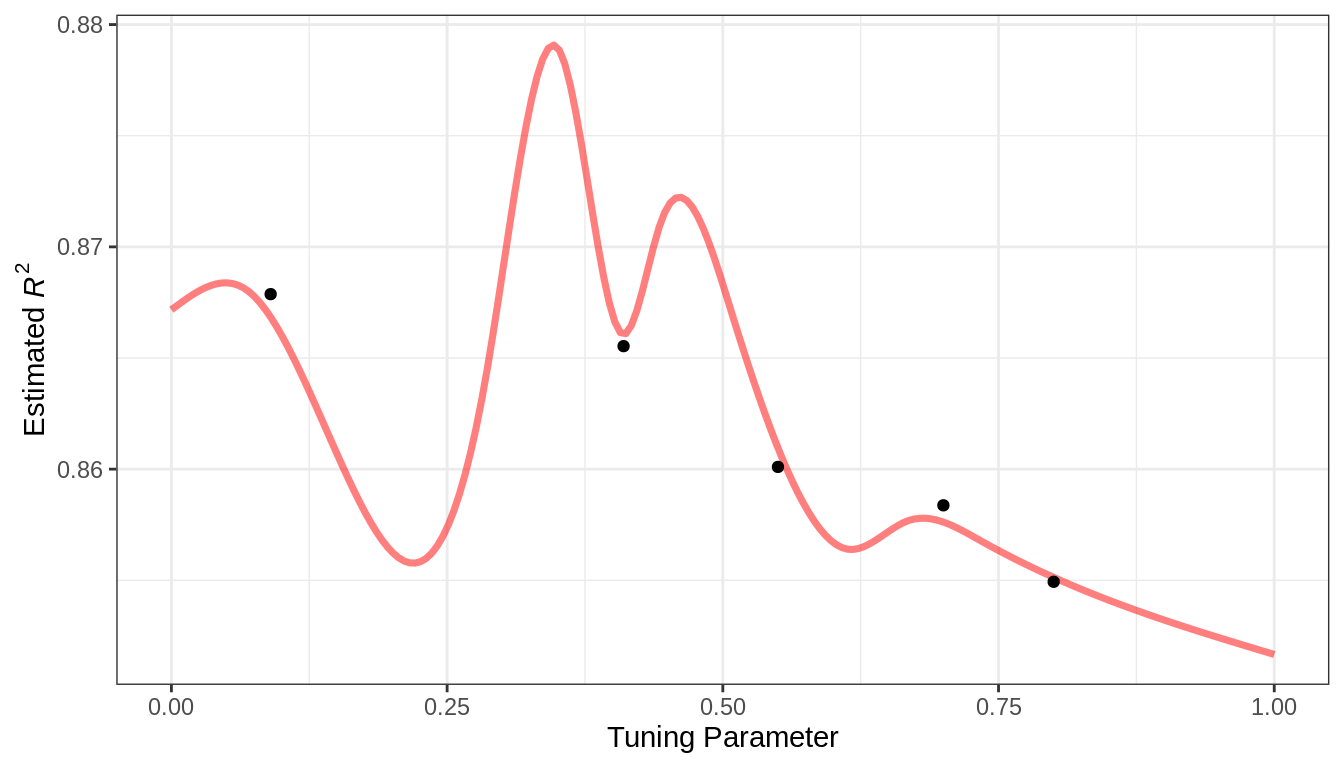

# 







- 가우시안 프로세스 모델에 의해 생성된 추정 성능 (음영 영역은 단일 표준 오차 한계를 나타냄)

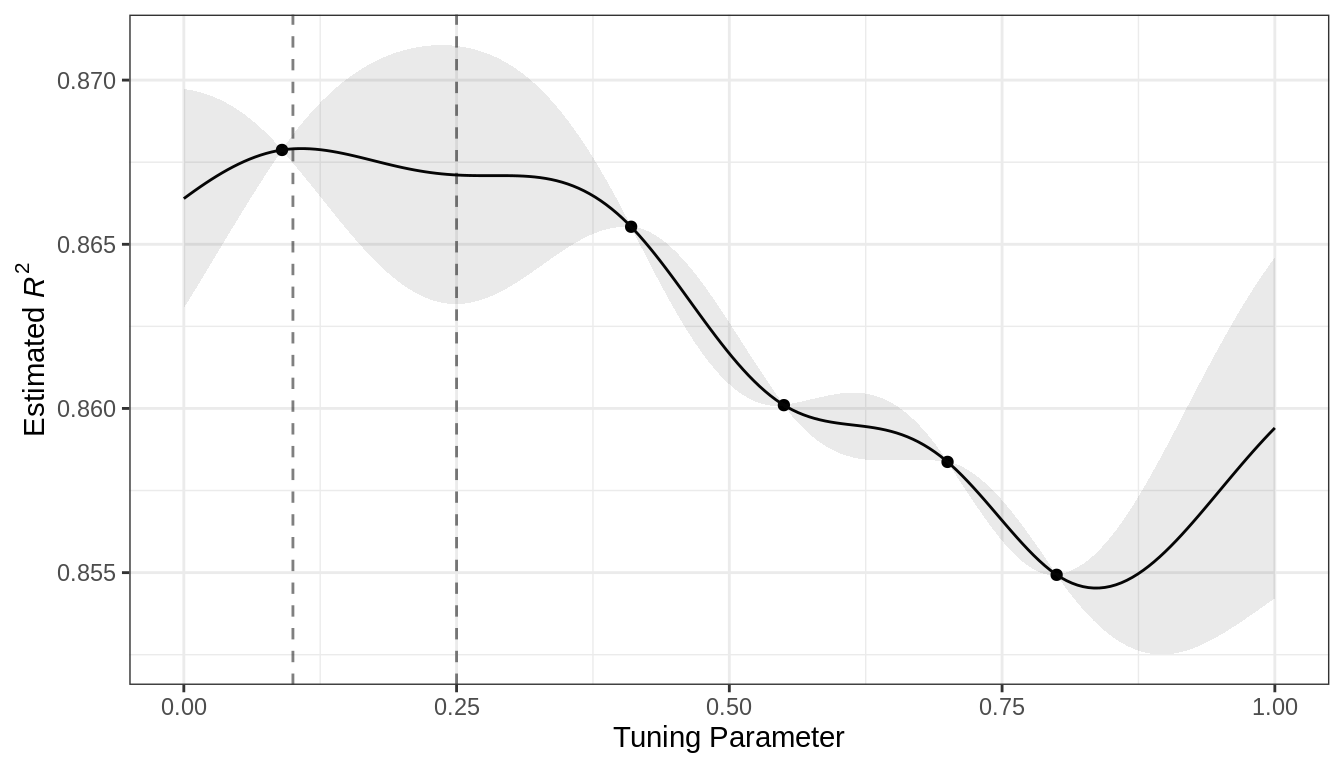

# 
# 
### ```tune_bayes()``` : 베이지안 최적화를 통해 반복 검색을 구현
- ```iter ``` : 최대 검색 반복 횟수
- ```initial ``` : ```tune_grid```를 사용하여 생성된 객체 또는 Racing method 중 하나. 정수를 입력하면 첫 번째 GP 모델 이전에 샘플링되는 '공간 채우기 설계'의 크기를 지정

- ```objective ``` : 획득 함수를 사용해야 하는 인수. tune 패키지에는 ```exp_inform()``` 또는 ```conf_bound()```와 같이 여기에 전달할 함수가 포함


- ```param_info ``` : 매개 변수의 범위뿐만 아니라 사용되는 변환도 지정. 서치 공간을 정의하는 데 사용. 기본 파라미터 개체가 부족한 상황에서는 ```param_info```를 사용하여 기본값을 재정의

# 

### ```control_bayes()``` : ```control```인수의 입력값으로 사용
- ```no_improve``` : ```no_improve()``` 반복 내에서 향상된 매개 변수가 검색되지 않을 경우 검색을 중지하는 정수입
- ```uncertain``` : 불확실한 반복 내에서 개선이 없는 경우 불확실성 표본을 추출하는 정수(또는 Inf) 이렇게 하면 변동이 큰 다음 후보가 선택. (평균 예측을 고려X)

# 
# 
# 

- SVM 결과를 가우시안 프로세스 모델의 초기 기판으로 사용 (ROC 곡선 아래의 면적을 최대화)






In [28]:
ctrl <- control_bayes(verbose = FALSE)

In [29]:
set.seed(1403)
svm_bo <- svm_wflow %>%
    tune_bayes(resamples = cell_folds,
               metrics = roc_res,
               initial = svm_initial,
               param_info = svm_param,
               iter = 25,
               control = ctrl)

# 
- 초기 최적값

In [24]:
collect_metrics(svm_initial)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.015625,1e-06,roc_auc,binary,0.8638724,10,0.008637894,Preprocessor1_Model1
2.000000,1e-06,roc_auc,binary,0.8625326,10,0.008672545,Preprocessor1_Model2
0.015625,1e-04,roc_auc,binary,0.8627495,10,0.008624554,Preprocessor1_Model3
2.000000,1e-04,roc_auc,binary,0.8659439,10,0.008545691,Preprocessor1_Model4


# 
# 

- 서치 프로세스는 ROC 곡선 아래의 영역에 대한 초기 최적 값 결과 0.8659로 시작
- 가우시안 프로세스 모형은, 이 네 가지 통계량을 사용하여 모형 생성. 
- 기대 개선 획득 함수를 사용하여 큰 후보 세트가 자동으로 생성되고 점수가 매겨짐. 
    - **첫 번째 반복은 ROC 값이 0.86315인 결과를 개선하는 데 실패**
    - **다른 가우스 프로세스 모델을 새로운 결과 값에 맞춘 후, 두 번째 반복도 개선을 산출하지 못함**

# 
```
#> Optimizing roc_auc using the expected improvement
#> 
#> ── Iteration 1 ──────────────────────────────────────────────────────────────────────
#> 
#> i Current best:      roc_auc=0.8659 (@iter 0)
#> i Gaussian process model
#> ✓ Gaussian process model
#> i Generating 5000 candidates
#> i Predicted candidates
#> i cost=0.386, rbf_sigma=0.000266
#> i Estimating performance
#> ✓ Estimating performance
#> ⓧ Newest results:    roc_auc=0.8631 (+/-0.00866)
#> 
#> ── Iteration 2 ──────────────────────────────────────────────────────────────────────
#> 
#> i Current best:      roc_auc=0.8659 (@iter 0)
#> i Gaussian process model
#> ✓ Gaussian process model
#> i Generating 5000 candidates
#> i Predicted candidates
#> i cost=13.8, rbf_sigma=7.83e-07
#> i Estimating performance
#> ✓ Estimating performance
#> ⓧ Newest results:    roc_auc=0.8624 (+/-0.00865)```

# 
# 
- 3, 4, 5, 6, 8, 13, 22, 23, 24의 iter에서 총 9번의 결과 개선이 존재. 
- 가장 좋은 결과는 ROC 곡선 아래의 면적이 0.8986인 24번째 iter에서 발생

```
#> ── Iteration 24 ─────────────────────────────────────────────────────────────────────
#> 
#> i Current best:      roc_auc=0.8986 (@iter 23)
#> i Gaussian process model
#> ✓ Gaussian process model
#> i Generating 5000 candidates
#> i Predicted candidates
#> i cost=31.8, rbf_sigma=0.0016
#> i Estimating performance
#> ✓ Estimating performance
#> ♥ Newest results:    roc_auc=0.8986 (+/-0.00785)```

# 
- 마지막 단계

```
#> ── Iteration 25 ─────────────────────────────────────────────────────────────────────
#> 
#> i Current best:      roc_auc=0.8986 (@iter 24)
#> i Gaussian process model
#> ✓ Gaussian process model
#> i Generating 5000 candidates
#> i Predicted candidates
#> i cost=20, rbf_sigma=0.00188
#> i Estimating performance
#> ✓ Estimating performance
#> ⓧ Newest results:    roc_auc=0.8982 (+/-0.00781)```

# 
# 

In [ ]:
show_best(svm_bo)

```
#> # A tibble: 5 × 9
#>    cost rbf_sigma .metric .estimator  mean     n std_err .config .iter
#>   <dbl>     <dbl> <chr>   <chr>      <dbl> <int>   <dbl> <chr>   <int>
#> 1  31.8   0.00160 roc_auc binary     0.899    10 0.00785 Iter24     24
#> 2  30.8   0.00191 roc_auc binary     0.899    10 0.00791 Iter23     23
#> 3  31.4   0.00166 roc_auc binary     0.899    10 0.00784 Iter22     22
#> 4  31.8   0.00153 roc_auc binary     0.899    10 0.00783 Iter13     13
#> 5  30.8   0.00163 roc_auc binary     0.899    10 0.00782 Iter15     15```

In [ ]:
autoplot(svm_bo, type = "performance")

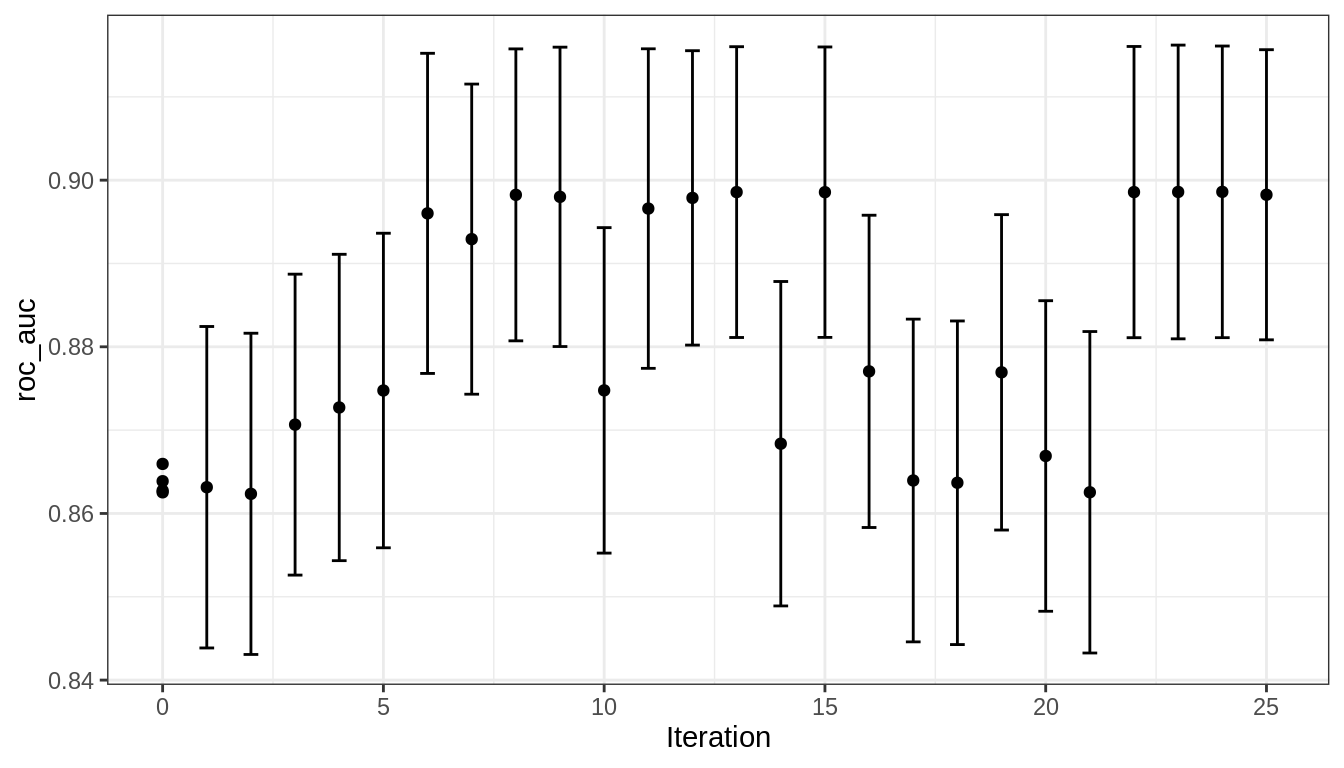

# 

- 서치 결과 시각화 : https://www.tmwr.org/bo_search.mp4
    - 검은색 $X$ 값은 ```svm_initial```에 포함된 시작 값을 의미
    - 왼쪽 위 파란색 패널에는 ROC 곡선 아래의 영역의 예측 평균 값이 표시 
    - 오른쪽 상단에 있는 빨간색 패널에는 ROC 값의 예측된 변동이 표시되고 아래쪽 그림은 예상되는 개선을 시각화
    - 각 패널에서 어두운 색상은 덜 매력적인 값 (예: 작은 평균 값, 큰 변동 및 작은 개선)을 나타냄
    
 # 
 
 - 처음 몇 번의 반복 서치에서 예측된 평균 표면의 표면은 매우 부정확
 - 그럼에도 불구하고, 좋은 성과를 내는 지역으로의 과정을 안내하는 데 도움 **다시 말해, 가우스 프로세스 모델은 잘못되었지만 그 자체가 매우 유용하다는 것을 보여줌**

# 
- 최상의 튜닝 파라미터 조합은 매개 변수 공간의 경계에 있지만, 베이지안 최적화는 종종 경계의 다른 측면에서 새로운 점을 선택
- 우리는 '탐색'와 '착취'의 비율을 조정할 수 있지만, 서치는 초기에 경계점을 샘플링하는 경향이 존재

# 

- 서치가 초기 그리드로 시드되는 경우 일반 설계보다 '공간 채우기 설계'가 더 나은 선택일
- 파라미터 공간의 고유한 값을 더 많이 샘플링하고 초기 반복에서 표준 편차의 예측을 개선








# 
# 
# 
## 14.3 Simulated Annealing
- 시뮬레이션 어닐링(SA)은 금속이 냉각되는 과정에서 영감을 얻은 일반적인 비선형 검색 루틴
- 불연속 기능을 포함하여 다양한 유형의 검색 환경을 효과적으로 탐색할 수 있는 전역 서치 방법
- 대부분의 그레이디언트 기반 최적화 루틴과 달리 시뮬레이션 어닐링은 이전 솔루션을 재평가



# 
### 14.3.1 시뮬레이션 어닐링 서치 프로세스
- 시뮬레이션된 어닐링 사용 프로세스는 초기 값으로 시작하여, 파라미터 공간을 통해 제어된 랜덤워크를 수행. 
- 각각의 새로운 후보 파라미터 값은 이전 값의 변화값. 

# 

- 후보 파라미터는 해당 성능 값을 얻기 위해 리샘플링 
- 이 값이 이전 파라미터보다 더 나은 결과를 얻을 경우, 새로운 최적 파라미터로 승인되고 프로세스가 지속
- 결과가 이전 값보다 나쁜 경우에도 서치 절차에서 이 파라미터를 사용하여 추가 단계를 정의
- 이는 두 가지 요인에 따라 달라짐 :
    - 첫째, 성능이 나빠질수록 나쁜 결과를 받아들일 가능성이 줄어든다. 즉, 성능이 크게 떨어지는 결과보다 약간 나쁜 결과가 허용 확률이 높음. 
    - 다른 요인은 서치 반복 횟수입니다. 시뮬레이션 어닐링에서는 검색이 진행될수록 더 적은 수의 차선의 값을 허용하려고 함. 
    
# 
    
    
- 이 두 요인에서 불량 결과에 대한 합격 확률은 다음과 같이 공식화 :

$\operatorname{Pr}[\text{accept suboptimal parameters at iteration } i] = \exp(c\times D_i \times i)$

- $i$ : 반복 번호, 
- $c$ : 사용자 지정 상수
- $D_i$ : 이전 값과 새 값 사이의 비율 차이(음수 값은 더 나쁜 결과를 의미). 
    - 나쁜 결과의 경우, 허용 확률을 결정하고, uniform 난수과 비교. 
    - 난수 값이 확률 값보다 크면, 서치는 현재 파라미터를 삭제
    - 반복하면, 이전 값 근처에 후보 값이 생성. 그렇지 않으면 다음 반복은 현재값을 기반으로 다음 파라미터 집합을 형성



# 
# 
- 다른 계수 값에 대한 시뮬레이션 어닐링 허용 확률의 히트맵


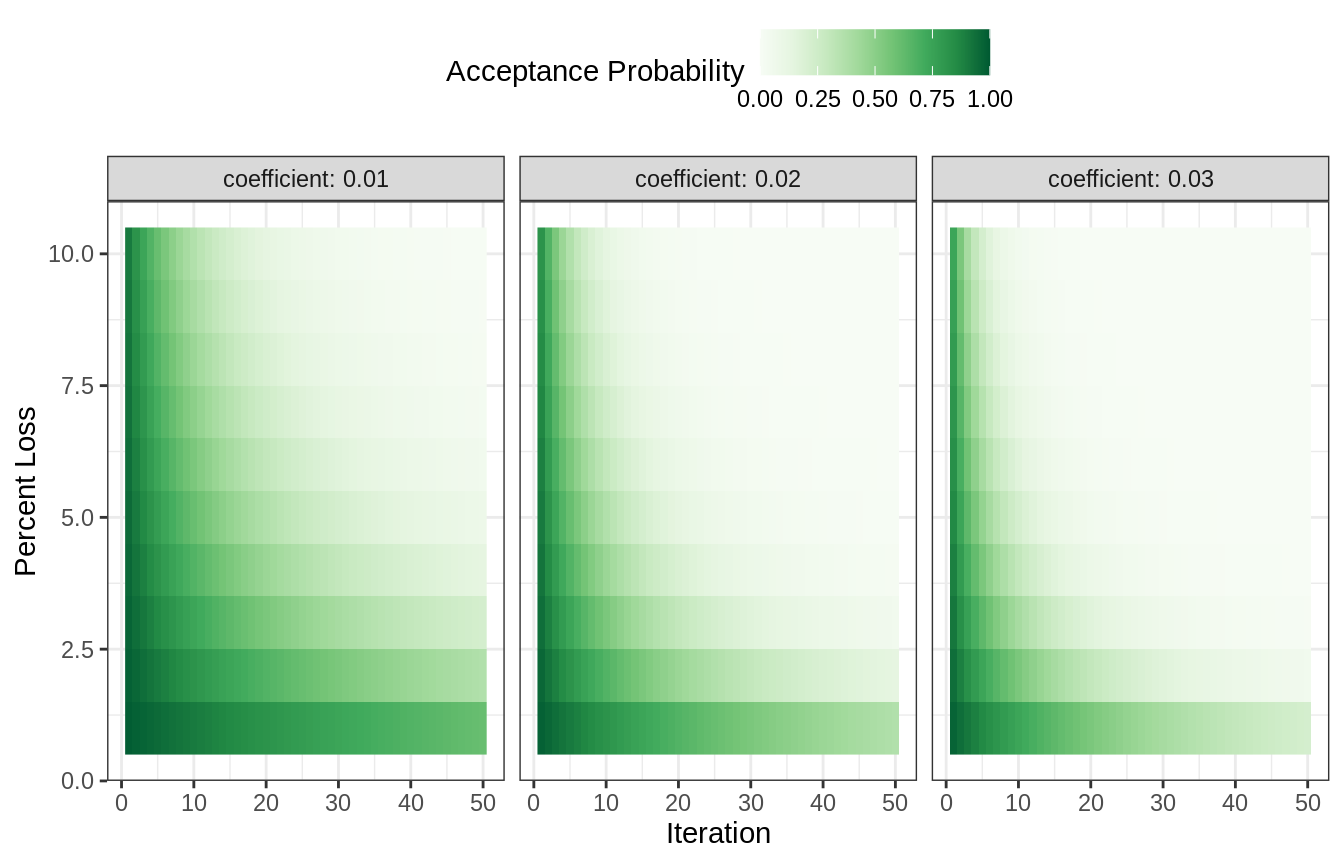

# 
# 
- 이 프로세스는 설정된 반복 횟수 동안 계속되지만, 사전 결정된 반복 횟수 내에 전체적으로 최상의 결과가 발생하지 않으면 중단될 수 있음. 
    - 재시작 임계값 설정가능. (일련의 오류가 있는 경우, 마지막으로 전역적인 최상의 매개 변수 설정을 다시 확인하고 새로 시작)


#  


- 시뮬레이션 어닐링이 두 튜닝 파라미터에 대한 로컬 이웃을 결정하는 방법에 대한 그림.
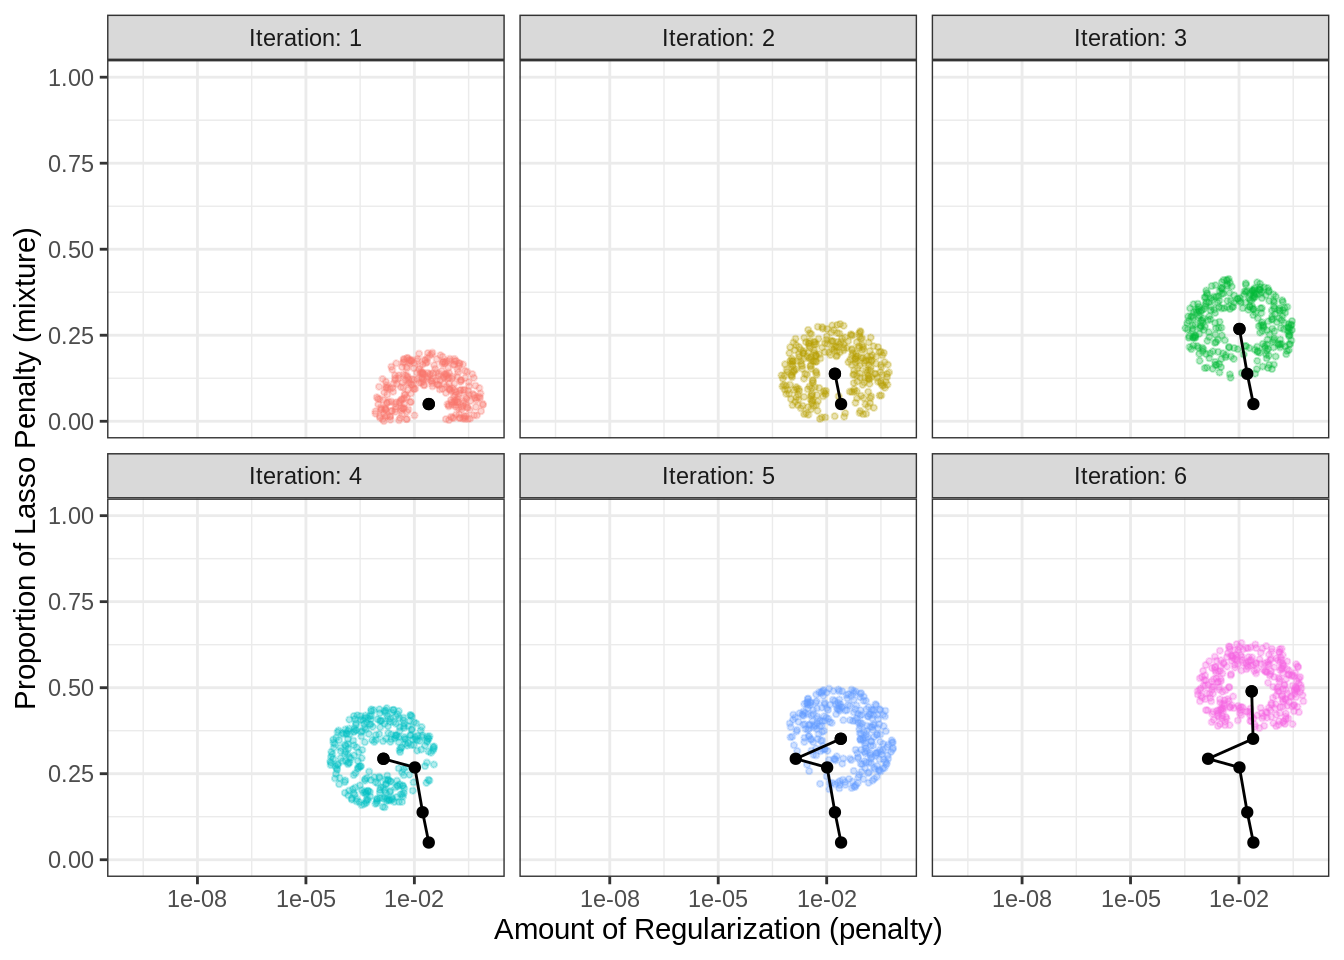



# 
# 
# 
### ```tune_sim_anneal()``` : 시뮬레이션 어닐링을 통해 반복 서치를 구현
- no_improve : no_improve 반복 내에서 전역 최고값 또는 개선된 결과가 발견되지 않을 경우 검색을 중지하는 정수. 승인된 차선의 파라미터 또는 폐기된 파라미터는 "개선 없음"으로 간주
- restart : 이전 최상의 결과에서 시작하기 전에, 새로운 최상의 결과가 없는 반복 횟수입니다.


- radius : (0, 1)의 숫자 벡터로서 초기점 주변의 지역 이웃의 최소 및 최대 반지름을 정의
- flip : 범주형 또는 정수형 모수의 값을 변경할 가능성을 정의하는 확률 값
- cooling_coef : $ exp ( c $ $\times $$D_i$ $\times$ $i)$에서 $c$의계수로서, 반복에 따라 허용 확률이 얼마나 빨리 감소하는지를 조절. ```cooling_coef``` 값이 클수록 차선의 파라미터 설정을 허용할 확률이 감소



In [33]:
library(finetune)

In [34]:
ctrl_sa <- control_sim_anneal(verbose = FALSE, no_improve = 10L)

In [35]:
set.seed(1404)
svm_sa <- svm_wflow %>%
    tune_sim_anneal(resamples = cell_folds,
                    metrics = roc_res,
                    initial = svm_initial,
                    param_info = svm_param,
                    iter = 50,
                    control = ctrl_sa)

Optimizing roc_auc
Initial best: 0.86594
 1 ( ) accept suboptimal  roc_auc=0.86351	(+/-0.008642)
 2 <3 new best           roc_auc=0.87334	(+/-0.008402)
 3 ( ) accept suboptimal  roc_auc=0.86724	(+/-0.00838)
 4 + better suboptimal  roc_auc=0.87042	(+/-0.008147)
 5 <3 new best           roc_auc=0.87444	(+/-0.008459)
 6 ( ) accept suboptimal  roc_auc=0.86966	(+/-0.00811)
 7 ( ) accept suboptimal  roc_auc=0.86589	(+/-0.008448)
 8 ( ) accept suboptimal  roc_auc=0.86233	(+/-0.008657)
 9 ( ) accept suboptimal  roc_auc=0.8623	(+/-0.008648)
10 + better suboptimal  roc_auc=0.86232	(+/-0.008658)
11 + better suboptimal  roc_auc=0.86238	(+/-0.008671)
12 + better suboptimal  roc_auc=0.86246	(+/-0.008646)
13 x restart from best  roc_auc=0.86254	(+/-0.008613)
14 ( ) accept suboptimal  roc_auc=0.87261	(+/-0.008351)
15 + better suboptimal  roc_auc=0.8728	(+/-0.008301)
16 <3 new best           roc_auc=0.88979	(+/-0.00886)
17 <3 new best           roc_auc=0.89188	(+/-0.008923)
18 <3 new best           roc

- 6번의 다른 반복에서 새로운 전역 최적점을 발견
- 가장 초기의 개선은 반복 2에서, 최종 최적화는 37번째 반복
- 13번, 26번, 45번째 반복에서 3번의 재시동, 그 과정에서 7번의 후보 폐기가 발생



In [38]:
show_best(svm_sa)

cost,rbf_sigma,.metric,.estimator,mean,n,std_err,.config,.iter
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
10.439221,0.003905738,roc_auc,binary,0.8979963,10,0.008253020,Iter37,37
2.745016,0.007152477,roc_auc,binary,0.8979348,10,0.008392826,Iter18,18
29.992035,0.002323313,roc_auc,binary,0.8978954,10,0.007740899,Iter42,42
19.775365,0.002932892,roc_auc,binary,0.8977000,10,0.007898298,Iter49,49
5.216009,0.003281398,roc_auc,binary,0.8976575,10,0.008244686,Iter36,36


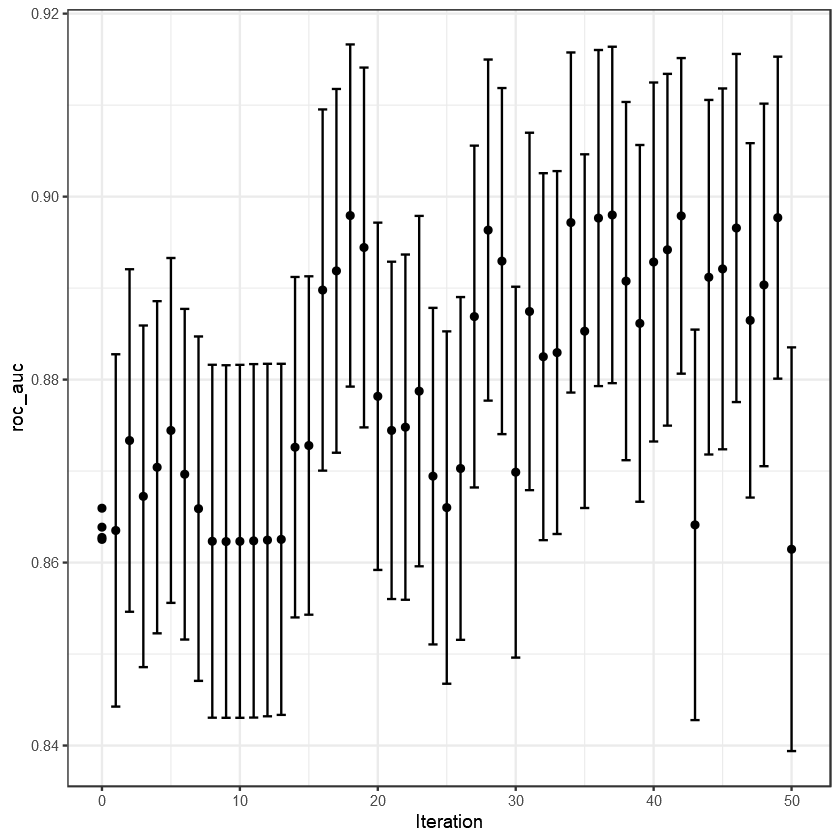

In [36]:
autoplot(svm_sa, type = "performance")

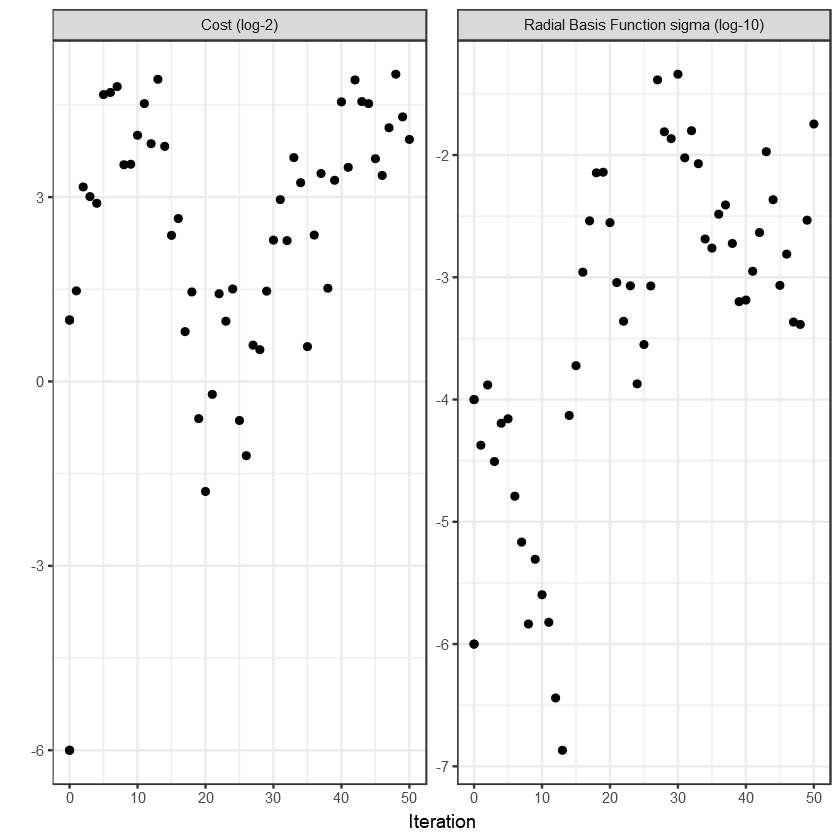

In [37]:
autoplot(svm_sa, type = "parameters")

# 

- 검색 경로 시각화 : https://www.tmwr.org/sa_search.mp4